# Comparison of Single Phase Diagam Points

## Finding best metric to evaluate complexity in input distribution

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [2]:
# Imports for curve fitting
from iminuit import Minuit
from scipy.integrate import quad

In [3]:
# Keras imports
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
def load_dataset(a, b):
    #
    num_snaps = 20000
    tdiff = 9.0
    grid_dataset_list = []
    file_index = 1
    alphas = np.linspace(0.2, 0.8, 4)
    betas = np.linspace(0.2, 0.8, 4)
    
    for alpha in alphas:
        for beta in betas:
            if alpha == a and beta == b:
                pair = (round(alpha, 2), round(beta, 2))
                grid_pt_data = pd.read_csv("RealTimeSnaps{}alpha{}beta{}tdiff{}.csv".format(num_snaps, pair[0], pair[1], tdiff), header=None)
                grid_pt_data['y'] = [file_index] * grid_pt_data.shape[0]
                grid_dataset_list.append(grid_pt_data)
                print('Alpha, Beta is {} and given label {}'.format(pair, file_index))
                file_index += 1
    
    grid_dataset = pd.concat(grid_dataset_list)

    X = grid_dataset.iloc[:, :-1]
    y = grid_dataset.iloc[:, -1]
    
    return X, y, file_index

In [5]:
Xmf, ymf, file_indexmf = load_dataset(0.2, 0.8)
Xcx, ycx, file_indexcx = load_dataset(0.2, 0.2)
Xmf_train, Xmf_test, ymf_train, ymf_test = train_test_split(Xmf, ymf, test_size=0.5)
Xcx_train, Xcx_test, ycx_train, ycx_test = train_test_split(Xcx, ycx, test_size=0.5)

Alpha, Beta is (0.2, 0.8) and given label 1
Alpha, Beta is (0.2, 0.2) and given label 1


In [3]:
class VAE:
    #
    def __init__(self, original_dim=100, intermediate_dim1=75, intermediate_dim2=50, latent_dim=1):
        #
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim1 = intermediate_dim1
        self.intermediate_dim2 = intermediate_dim2
        
    def sampling(self, args):
        # Unpack arguments
        z_mean, z_log_var = args
        # Get shape of random noise to sample
        epsilon = K.random_normal(shape=K.shape(z_mean))
        # Return samples from latent space p.d.f.
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    def build_vae(self):
        #
        original_dim = self.original_dim
        latent_dim = self.latent_dim
        intermediate_dim1 = self.intermediate_dim1
        intermediate_dim2 = self.intermediate_dim2
        
        # encoder
        inputs = Input(original_dim, name='input')
        x = Dense(intermediate_dim1, activation='relu')(inputs)
        x = Dense(intermediate_dim2, activation='relu')(x)
        z_mean = Dense(latent_dim, name="z_mean")(x)
        z_log_var = Dense(latent_dim, name="z_log_var")(x)
        z = Lambda(self.sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        
        #decoder
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x = Dense(intermediate_dim2, activation='relu')(latent_inputs)
        x = Dense(intermediate_dim1, activation='relu')(x)
        outputs = Dense(original_dim, activation='sigmoid')(x)
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        
        i = self.encoder.inputs
        if len(i) == 1:
            i = i[0]
            pass
        z = self.encoder(i)[2]
        o = self.decoder(z)
        self.vae = Model(i, o, name='VAE')
        
    def compile_vae(self):
        # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
        encoder   = self.vae.get_layer('encoder')
        z_log_var = encoder.get_layer('z_log_var').output
        z_mean    = encoder.get_layer('z_mean').output

        # Define reconstruction loss
        def reco_loss(y_true, y_pred):
            # Use binary cross-entropy loss
            reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
            reco_loss_value = K.sum(reco_loss_value)
            return reco_loss_value

        # Define Kullback-Leibler loss with reference to encoder output layers
        def kl_loss(y_true, y_pred):
            kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
            kl_loss_value = K.sum(kl_loss_value, axis=-1)
            return kl_loss_value

        # Define VAE loss
        def vae_loss(y_true, y_pred):
            return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

        self.vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
        return
    
    def get_summaries(self):
        #
        return [self.encoder.summary(),
                self.decoder.summary(),
                self.vae.summary()]
    
    def get_architectures(self):
        #
        return [plot_model(self.encoder, show_shapes=True),
                plot_model(self.decoder, show_shapes=True),
                plot_model(self.vae, show_shapes=True)]

In [7]:
MFvae = VAE()
MFvae.build_vae()
MFvae.compile_vae()
CXvae = VAE()
CXvae.build_vae()
CXvae.compile_vae()

In [8]:
nb_epochs  = 10
batch_size = 32

In [9]:
mf_history = MFvae.vae.fit(Xmf_train, Xmf_train,
                           epochs=nb_epochs,
                           batch_size=batch_size,
                           shuffle=True,
                           validation_split=0.2,
                           verbose=False)

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [10]:
cx_history = CXvae.vae.fit(Xcx_train, Xcx_train,
                           epochs=nb_epochs,
                           batch_size=batch_size,
                           shuffle=True,
                           validation_split=0.2,
                           verbose = False)

In [11]:
def plot_losses(vae_history, name, ax):
    #
    ax.plot(vae_history.history['loss'], label= name+' training loss')
    ax.plot(vae_history.history['reco_loss'], label=name+' training reconstruction loss')
    #ax.plot(vae_history.history['kl_loss'], label=name+' training kl loss')
    ax.plot(vae_history.history['val_loss'], label=name+' validation loss')
    ax.plot(vae_history.history['val_reco_loss'], label=name+' validation reconstruction loss')
    #ax.plot(vae_history.history['val_kl_loss'], label=name+' validation kl loss')
    ax.legend(loc="best")

In [12]:
def plot_z_distribution(z_samples, fit_mu, fit_sigma, name, ax):
    #
    counts, bin_edges, _ = ax.hist(z_samples[:, 0],bins='auto', density=True, label=name+' z samples')
    tot_bin_edges = np.array(bin_edges)
    half_bin_width = (tot_bin_edges[1] - tot_bin_edges[0]) / 2.
    zs = (tot_bin_edges + half_bin_width)[:-1]
    ax.plot(zs, gaussian_pdf(zs, fit_mu, fit_sigma), label=name+' Gaussian fit')
    ax.legend(loc="best")

In [13]:
def plot_z_example(z, decoder, name, ax):
    #
    ax.scatter(list(range(100)), decoder.predict(np.array([z])), label=name+' z = '+str(z))
    ax.set_ylim(0, 1)
    ax.legend()

In [14]:
def gaussian_pdf(z, mu, sigma):
    #
    return (1./(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((z - mu)/sigma)**2)

In [15]:
def nllmf(mu, sigma):
    #
    return -1 * np.sum(np.log(gaussian_pdf(mfz_samples, mu, sigma)))

In [16]:
def nllcx(mu, sigma):
    #
    return -1 * np.sum(np.log(gaussian_pdf(cxz_samples, mu, sigma)))

In [17]:
_, _, mfz_samples = MFvae.encoder.predict(Xmf_test)
_, _, cxz_samples = CXvae.encoder.predict(Xcx_test)

In [18]:
# fit Minuit, with initial guesses for background lifetime, signal mean and background fraction F
fitmf = Minuit(nllmf, mu=0., sigma=1.)
fitcx = Minuit(nllcx, mu=0., sigma=1.)
# definition of error for nll given in notes
fitmf.errordef = 0.5
fitcx.errordef = 0.5

In [19]:
fitmf.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.425e+04                  │              Nfcn = 48               │
│ EDM = 0 (Goal: 0.0001)           │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  -0.000   │   0.009   │            │            │         │         │       │
│ 1 │ sigma │   1.007   │   0.006   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 7.92e-05 6.46e-06 │
│ sigma │ 6.46e-06  3.8e-05 │
└───────┴───────────────────┘

In [20]:
fitcx.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.454e+04                  │              Nfcn = 34               │
│ EDM = 0.000305 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │   0.070   │   0.011   │            │            │         │         │       │
│ 1 │ sigma │   1.036   │   0.007   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 0.000125        0 │
│ sigma │        0 4.69e-05 │
└───────┴───────────────────┘

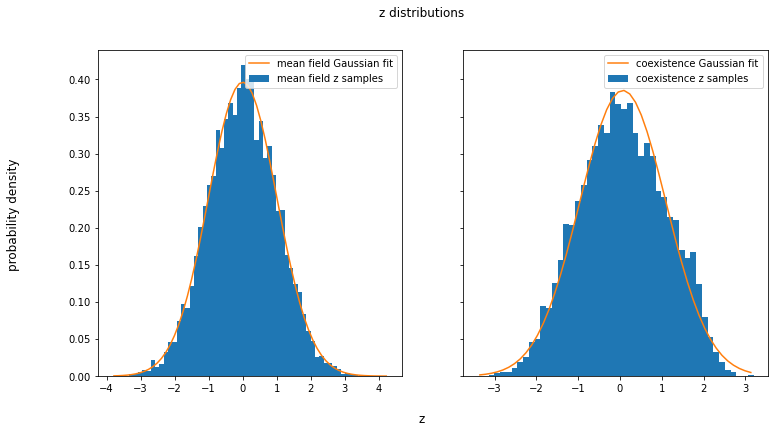

In [21]:
mu_fitmf = fitmf.values["mu"]
sigma_fitmf = fitmf.values["sigma"]
mu_fitcx = fitcx.values["mu"]
sigma_fitcx = fitcx.values["sigma"]
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('z distributions')
fig.supxlabel('z')
fig.supylabel('probability density')
plot_z_distribution(mfz_samples, mu_fitmf, sigma_fitmf, 'mean field', axs[0])
plot_z_distribution(cxz_samples, mu_fitcx, sigma_fitcx, 'coexistence', axs[1])
plt.savefig('Comparison_z_dist')
plt.show()

In [86]:
#lat_length = 100
#zstart = -4.
#zstop = 4.
#znum = 1000
#zrange = np.linspace(zstart, zstop, znum)
num_pts = 500

In [87]:
def config_taus(rhos):
    #
    taus = np.zeros(lat_length)
    for i in range(lat_length):
        if random.random() <= rhos[i]:
            taus[i] = 1
    return taus

In [88]:
def calc_mfpoftaus(rhos, taus):
    #
    return np.prod(rhos**taus * (1-rhos)**(1-taus))

In [89]:
def calc_complexity1(z_samples, decoder):
    avg_1 = 0
    for i in range(num_pts):
        sample0 = random.choice(z_samples)
        rhos0 = decoder.predict(np.array([sample0]))[0]  
        taus0 = config_taus(rhos0)
        avg_0 = 0
        for i in range(num_pts):
            sample1 = random.choice(z_samples)
            rhos1 = decoder.predict(np.array([sample1]))[0]  
            avg_0 += calc_mfpoftaus(rhos1, taus0)
        avg_0 /= num_pts
        avg_1 += np.log(avg_0)
    avg_1 /= num_pts
    
    avg_2 = 0
    for i in range(num_pts):
        sample2 = random.choice(z_samples)
        rhos2 = decoder.predict(np.array([sample2]))[0]
        avg_0b = 0
        for i in range(num_pts):
            sample_prime = random.choice(z_samples)
            rhos_prime = decoder.predict(np.array([sample_prime]))[0]
            taus_prime = config_taus(rhos_prime)
            avg_0b += np.log(calc_mfpoftaus(rhos2, taus_prime))
        avg_0b /= num_pts
        avg_2 += avg_0b
    avg_2 /= num_pts
    
    return avg_1 - avg_2

In [90]:
mf_complexity1 = calc_complexity1(mfz_samples, MFvae.decoder)
cx_complexity1 = calc_complexity1(cxz_samples, CXvae.decoder)

In [91]:
def calc_complexity2(z_samples, decoder):
    avg_A = 0
    for i in range(num_pts):
        sample_A = random.choice(z_samples)
        rhos_A = decoder.predict(np.array([sample_A]))[0]
        sum_A = np.sum(rhos_A*np.log(rhos_A) + (1-rhos_A)*np.log(1-rhos_A))
        avg_A += sum_A
    avg_A /= num_pts
    
    avg_rhos = 0
    for i in range(num_pts):
        sample_B = random.choice(z_samples)
        rhos_B = decoder.predict(np.array([sample_B]))[0]
        avg_rhos += rhos_B
    avg_rhos /= num_pts
    sum_B = np.sum(avg_rhos*np.log(avg_rhos) + (1-avg_rhos)*np.log(1-avg_rhos))
    
    return avg_A - sum_B

In [92]:
mf_complexity2 = calc_complexity2(mfz_samples, MFvae.decoder)
cx_complexity2 = calc_complexity2(cxz_samples, CXvae.decoder)

In [93]:
print('Mean-field: complexity1 = {}, complexity2 = {}'.format(mf_complexity1, mf_complexity2))
print('Coexistence: complexity1 = {}, complexity2 = {}'.format(cx_complexity1, cx_complexity2))

Mean-field: complexity1 = 0.01745198891806865, complexity2 = -0.03461240386963027
Coexistence: complexity1 = 17.804789758492568, complexity2 = 9.505138694763183
